# ESRB Rating Project

## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#INTRODUCTION)<br>**
1 -**[ OBTAIN](#OBTAIN)**<br>
2 -**[ SCRUB](#SCRUB)**<br>
3 -**[ EXPLORE](#EXPLORE)**<br>
4 -**[ MODEL](#MODEL)**<br>
5 -**[ INTERPRET](#INTERPRET)**<br>
6 -**[ CONCLUSIONS & RECCOMENDATIONS](#Conclusions-&-Recommendations)<br>**
</font>
___

# INTRODUCTION

- Student: Cody Freese
- Pace: Self Paced
- Jeff Herman

- ESRB Ratings Board Dataset
    - Objective
        - Develop a model with high confidence in predicting games potential rating
        - Identify impact variables have on rating
        - Strive for overall accuracy and low false positive/negative. High F1 Score

## Import Tools

In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

from matplotlib import rcParams

import statsmodels as sm

import sklearn.preprocessing as preprocessing

from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor)

from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor)

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import (classification_report, 
                             confusion_matrix)

from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

## Functions

In [295]:
#Classification Function
def classification(X_train, y_train,X_test,y_test, classifier):
    '''
    Generates Confusion Matrix & Prints Accuracy Score
    :param X_train: DataFrame
    :param y_train: DataFrame
    :param X_test: DataFrame
    :param y_test: DataFrame
    :param classifier: Class
    :return None: calls matplotlib show() & prints out Accuracy Score
    '''
    # Y predictor
    y_pred = classifier.predict(X_test)
    fig, ax = plt.subplots(figsize=(8,8))
    #plot confusion matrix
    plot_confusion_matrix(estimator=classifier, X=X_test, y_true=y_test, ax=ax, cmap='PuBuGn')
    # show figure
    plt.show()
    # Print Classification Accuracy
    print(classification_report(y_test, y_pred))
    print(f'Accuracy:{round(accuracy_score(y_test,y_pred)*100, 2)}%')

In [285]:
def plot_game_consoles(df):
    '''
    Total count of each Console, displays visualization
    :param df: DataFrame
    :return None: calls matplotlib show()
    '''
    # Value count function, if the title exists in both consoles will make 3rd category called Available on Both
    value_count = {}
    #Loop iterating through title and console
    for title, console in df[['title', 'console']].values:
        # If the Title and exists in both consoles will make it 'Available on Both'
        if title in value_count and value_count[title] != console:
            value_count[title] = 'Available on Both'
        # Else will separate title into correspoonding console
        else:
            value_count[title] = 'Xbox' if console == 1 else 'Playstation'
    # Subplot series of value counts of each category
    engineered_series = pd.Series(value_count).value_counts()
    fig, (ax) = plt.subplots(ncols=1, figsize=(12,6))
    #Bar plot
    engineered_series.plot(kind='bar', ax=ax,color=["blue","green","red"])
    # Title
    ax.set(title='Game Distribution For Console Type', xlabel='Consoles', ylabel='# of Games')
    # Show graphic
    plt.show()

In [286]:
def plot_game_ratings(df):
    '''
    Total count of each Rating, displays visualization
    Arguements
    :param df: DataFrame
    Returns: None, calls matplotlib show()
    '''
    # Makes a count of the number of games in each rating
    rating_count = {"E":0,"ET":0,"T":0,"M":0}
    for rating in df['esrb_rating'].values:
        if rating ==0:
            rating_count["E"] += 1
        if rating ==1:
            rating_count["ET"] += 1
        if rating ==2:
            rating_count["T"] += 1
        if rating ==3:
            rating_count["M"] += 1
    #Subplot series of rating counts
    rating_series = pd.Series(rating_count)
    fig,(ax) = plt.subplots(ncols=1,figsize=(12,6))
    # Bar plot
    rating_series.plot(kind='bar',ax=ax, color=["blue","green","orange","red"])
    # Title
    ax.set(title='Rating Distribution for Games', xlabel='Ratings',ylabel='# of Games')
    fig.tight_layout()
    # Show graphic
    plt.show()

# OBTAIN

In [172]:
# Import Test CSV
test_df = pd.read_csv('test_esrb.csv')
# Import Train CSV
train_df = pd.read_csv('Video_games_esrb_rating.csv')

In [173]:
#Combine the Train/Test CSVs into one
combined_csv = test_df.append(train_df)
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 0 to 1894
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     2395 non-null   object
 1   console                   2395 non-null   int64 
 2   alcohol_reference         2395 non-null   int64 
 3   animated_blood            2395 non-null   int64 
 4   blood                     2395 non-null   int64 
 5   blood_and_gore            2395 non-null   int64 
 6   cartoon_violence          2395 non-null   int64 
 7   crude_humor               2395 non-null   int64 
 8   drug_reference            2395 non-null   int64 
 9   fantasy_violence          2395 non-null   int64 
 10  intense_violence          2395 non-null   int64 
 11  language                  2395 non-null   int64 
 12  lyrics                    2395 non-null   int64 
 13  mature_humor              2395 non-null   int64 
 14  mild_blood              

# SCRUB

- Datatypes appear correct

# EXPLORE

## Pivot Table

In [174]:
#Organized table by Rating and Console, used as organization check
combined_csv.pivot_table(index=["esrb_rating","console"])

alcohol_reference  animated_blood     blood  \
esrb_rating console                                                
E           0                 0.035857        0.000000  0.000000   
            1                 0.033962        0.000000  0.000000   
ET          0                 0.129747        0.006329  0.000000   
            1                 0.061033        0.037559  0.000000   
M           0                 0.000000        0.000000  0.436275   
            1                 0.003663        0.000000  0.388278   
T           0                 0.039916        0.010504  0.430672   
            1                 0.073048        0.012594  0.387909   

                     blood_and_gore  cartoon_violence  crude_humor  \
esrb_rating console                                                  
E           0              0.000000          0.000000     0.003984   
            1              0.000000          0.000000     0.007547   
ET          0              0.000000          0.006329     0.069620   
            1              0.000000          0.117371     0.061033   
M           0              0.406863          0.000000     0.029412   
            1              0.578755          0.000000     0.003663   
T           0              0.084034          0.010504     0.048319   
            1              0.060453          0.040302     0.138539   

                     drug_reference  fantasy_violence  intense_violence  \
esrb_rating console                                                       
E           0              0.000000          0.000000          0.000000   
            1              0.000000          0.000000          0.000000   
ET          0              0.012658          0.715190          0.085443   
            1              0.037559          0.582160          0.084507   
M           0              0.053922          0.117647          0.186275   
            1              0.069597          0.095238          0.315018   
T           0              0.056723          0.222689          0.132353   
            1              0.032746          0.113350          0.075567   

                     language  ...  partial_nudity  sexual_content  \
esrb_rating console            ...                                   
E           0        0.000000  ...        0.000000        0.000000   
            1        0.000000  ...        0.000000        0.000000   
ET          0        0.072785  ...        0.003165        0.000000   
            1        0.070423  ...        0.000000        0.000000   
M           0        0.161765  ...        0.068627        0.112745   
            1        0.172161  ...        0.069597        0.073260   
T           0        0.195378  ...        0.027311        0.050420   
            1        0.148615  ...        0.017632        0.020151   

                     sexual_themes  simulated_gambling  strong_janguage  \
esrb_rating console                                                       
E           0             0.000000            0.000000         0.000000   
            1             0.000000            0.000000         0.000000   
ET          0             0.000000            0.009494         0.000000   
            1             0.000000            0.004695         0.004695   
M           0             0.230392            0.142157         0.500000   
            1             0.117216            0.124542         0.509158   
T           0             0.039916            0.048319         0.008403   
            1             0.040302            0.120907         0.010076   

                     strong_sexual_content  suggestive_themes  use_of_alcohol  \
esrb_rating console                                                             
E           0                     0.000000           0.000000        0.000000   
            1                     0.000000           0.000000        0.000000   
ET          0                     0.006329           0.075949        0.025316   
            1                  

## Describe

In [175]:
#Checking values, values <= 1% Mean
#Animated_Blood
combined_csv.describe()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
count,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,...,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.00000,2395.000000,2395.000000
mean,0.479332,0.050522,0.008351,0.231315,0.127349,0.020042,0.051357,0.034238,0.230063,0.109395,...,0.022547,0.031315,0.047599,0.057620,0.104384,0.038831,0.108977,0.03048,0.022965,0.114823
std,0.499677,0.219065,0.091019,0.421762,0.333433,0.140172,0.220771,0.181878,0.420961,0.312199,...,0.148485,0.174205,0.212961,0.233072,0.305822,0.193232,0.311675,0.17194,0.149822,0.318874
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## Binary Count

In [176]:
#Get a count of possible duplicate titles that exist in both console categories (Binary Yes/No)
#Count of Yes/No for each variable
for column in combined_csv:
    print(combined_csv[column].value_counts())

Destiny 2                             2
Elite Dangerous: Legendary Edition    2
Cosmic Star Heroine                   2
2064: Read Only Memories              2
Fortnite                              2
                                     ..
Siralim                               1
Where the Water Tastes Like Wine      1
Lichtspeer                            1
Heroland - 'Knowble Edition'          1
Bravo Team                            1
Name: title, Length: 2332, dtype: int64
0    1247
1    1148
Name: console, dtype: int64
0    2274
1     121
Name: alcohol_reference, dtype: int64
0    2375
1      20
Name: animated_blood, dtype: int64
0    1841
1     554
Name: blood, dtype: int64
0    2090
1     305
Name: blood_and_gore, dtype: int64
0    2347
1      48
Name: cartoon_violence, dtype: int64
0    2272
1     123
Name: crude_humor, dtype: int64
0    2313
1      82
Name: drug_reference, dtype: int64
0    1844
1     551
Name: fantasy_violence, dtype: int64
0    2133
1     262
Name: intense_vio

## Duplicate Titles

In [177]:
pd.DataFrame(combined_csv["title"].value_counts()[combined_csv["title"].value_counts() > 1]).index
#Count of Duplicate Titles across platforms

Index(['Destiny 2', 'Elite Dangerous: Legendary Edition',
       'Cosmic Star Heroine', '2064: Read Only Memories', 'Fortnite', 'Jak 3',
       'South Park: The Stick of Truth',
       'River City Melee: Battle Royal Special', 'BUTCHER',
       'RAID: WORLD WAR II', 'Super GunWorld 2', 'The Long Dark', 'Late Shift',
       'Future Unfolding', 'Nex Machina', 'Transport Giant',
       'Wonder Boy: The Dragon's Trap', 'BLACKHOLE: Complete Edition',
       'Human Fall Flat', 'Jak II', 'Momodora: Reverie Under the Moonlight',
       'Jak X: Combat Racing', '88 Heroes', 'SHINY', 'Mages of Mystralia',
       'INSIDE', 'Children of Zodiarcs', 'Polybius',
       'Fallen Legion: Sins of an Empire', 'Surf World Series',
       'Super Comboman: Smash Edition', 'Thimbleweed Park', 'The Inner World',
       'Revenant Saga', 'Island Flight Simulator', 'Cities: Skylines',
       'Still Time', 'forma.8', 'IRON CRYPTICLE',
       'The Metronomicon: Slay the Dance Floor', '3D MiniGolf', 'Windjammers',
  

In [178]:
#Number of duplicates in value count list
len(pd.DataFrame(combined_csv["title"].value_counts()[combined_csv["title"].value_counts() > 1]).index)

63

## Variable difference between consoles example

In [179]:
combined_csv[combined_csv['title']=="South Park: The Stick of Truth"]
#Variables don't match for the same game/sometimes same console
#South Park used as example
#Future Work could include further decision making about which to keep/drop/etc

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
16,South Park: The Stick of Truth,1,0,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,M
1514,South Park: The Stick of Truth,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,M


## Map Ratings

In [180]:
# Set Order To Categories
mapp = {'E' : 0,
        'ET': 1,
        'T' : 2,
        'M' : 3,
}

combined_csv['esrb_rating'] = combined_csv['esrb_rating'].map(mapp)

## EDA by Platform

In [181]:
#Where Duplicated Titles
combined_csv.drop_duplicates(inplace=True)
#Rows where titles are duplicated, consoles are different AND will drop row if the row is an exact duplicate
combined_csv[combined_csv['title'].duplicated(keep=False)]

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Still Time,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,The Metronomicon: Slay the Dance Floor,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
16,South Park: The Stick of Truth,1,0,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,3
22,Mages of Mystralia,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
31,Super Comboman: Smash Edition,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,Crawl,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,2
1810,The Inner World,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,2
1833,RAID: WORLD WAR II,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
1885,Pillars of Eternity,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,3


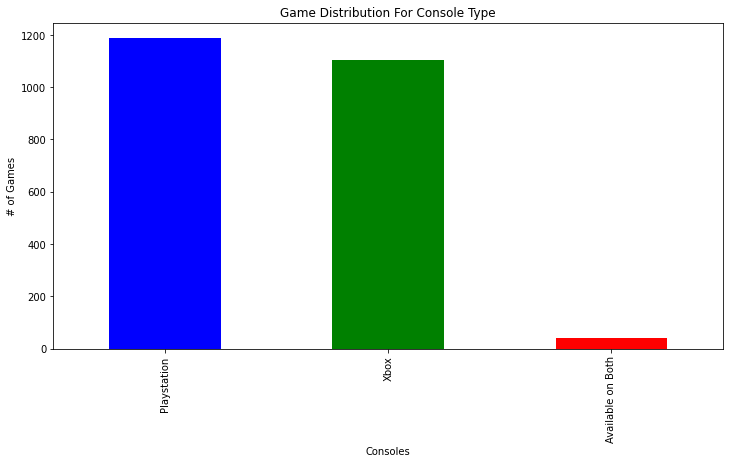

In [287]:
#Game Distribution & visualization of overlap
plot_game_consoles(combined_csv)

## EDA By Rating

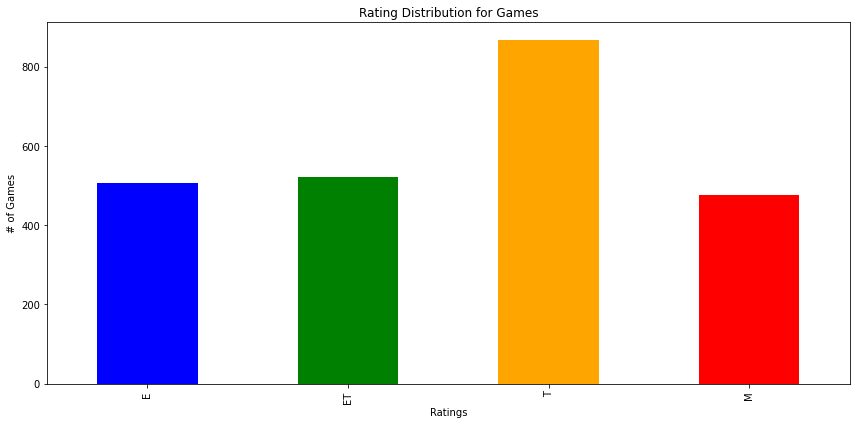

In [288]:
#Game Distribution by Rating
plot_game_ratings(combined_csv)

## Heatmap

In [184]:
# Create correlation matrix
corr = combined_csv.corr()
# Mask copied upper triangle of correlation to be hidden
mask = np.triu(np.ones_like(corr, dtype=np.bool))

In [257]:
fig, ax = plt.subplots(figsize=(25,20))
# Numeric correlation to 3 digits
corr = combined_csv.corr().round(3)
# Seaborn Heatmap
sb.heatmap(corr, annot=True,ax=ax, mask=mask)
# Setup figure
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
# Title
ax.set_title('Correlations')
fig.tight_layout()

SyntaxError: positional argument follows keyword argument (<ipython-input-257-82b0b0664583>, line 5)

In [186]:
# 

## Histogram

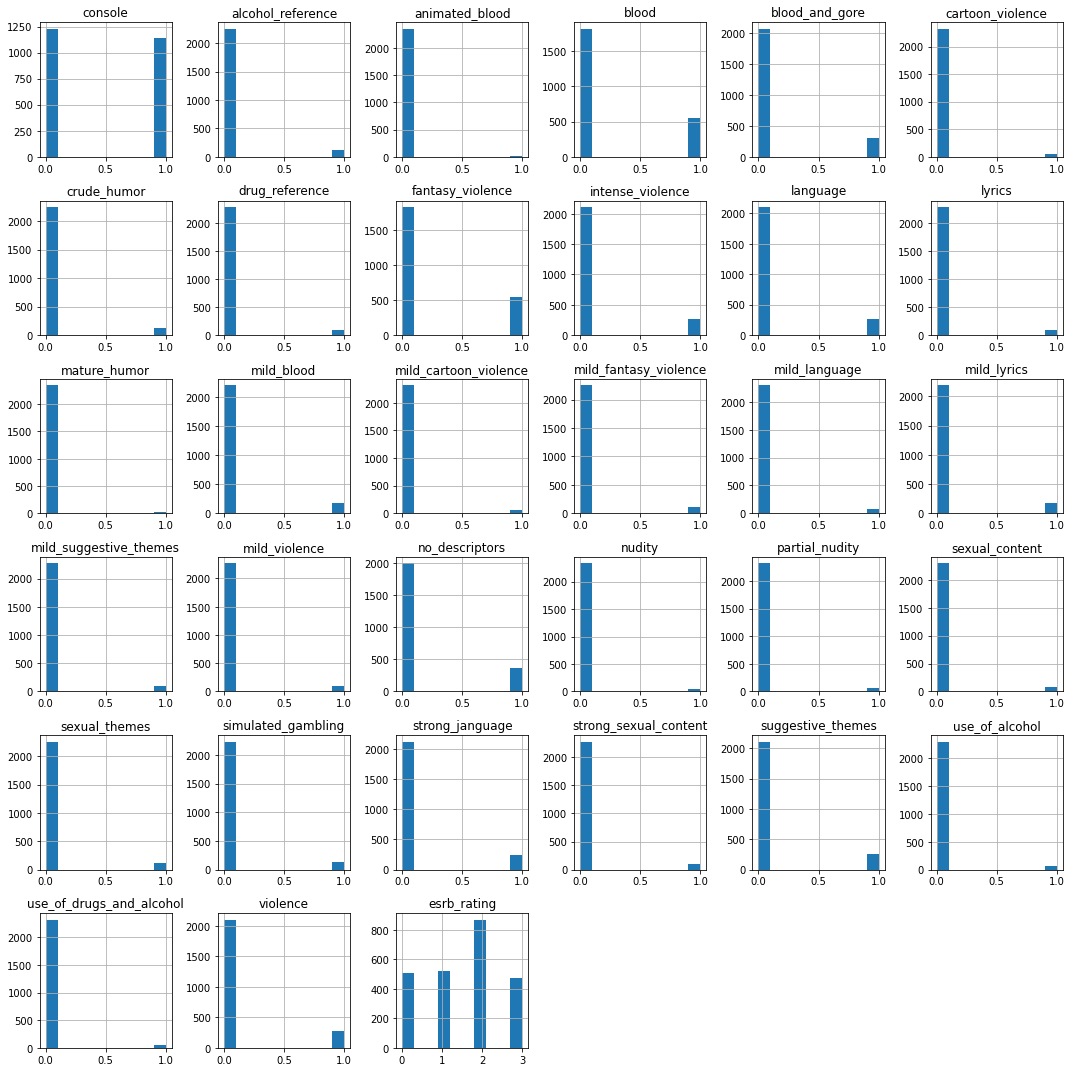

In [187]:
#histogram check
combined_csv.hist(figsize=(15,15))
plt.tight_layout()

# MODEL

## Train Test Split

In [188]:
#X variables drop Rating and Title
X = combined_csv.drop(['esrb_rating', 'title'],1)

#Y variable is Rating
y = combined_csv['esrb_rating']

#Train test split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 354681)

## Initial Model & Observations - No Parameters

### Decision Tree

In [189]:
#decision tree, initial classifier, no parameters
dtc = DecisionTreeClassifier()
#fit decision tree to train test split
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [190]:
#Initial dtc training score
dtc.score(X_train, y_train)

0.9282700421940928

In [191]:
#Initial dtc test score
dtc.score(X_test, y_test)

0.8398876404494382

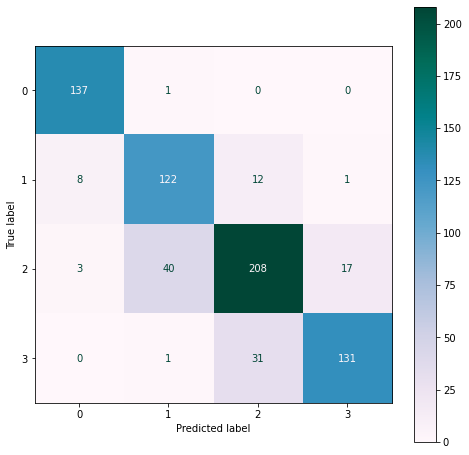

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.74      0.85      0.79       143
           2       0.83      0.78      0.80       268
           3       0.88      0.80      0.84       163

    accuracy                           0.84       712
   macro avg       0.84      0.86      0.85       712
weighted avg       0.84      0.84      0.84       712

Accuracy:83.99%


In [296]:
#Confusion matrix, initial dtc classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=dtc)

### KNN

In [193]:
#knn, initial classifier, no parameters
knn = KNeighborsClassifier()

#fit knn to train test split
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [194]:
#Initial KNN training score
knn.score(X_train, y_train)

0.8468957203134418

In [195]:
#Initial knn test score
knn.score(X_test, y_test)

0.7865168539325843

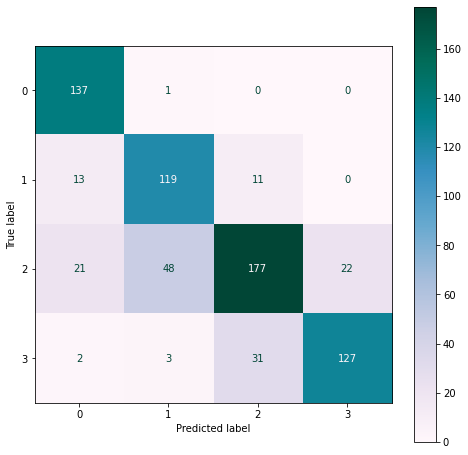

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       138
           1       0.70      0.83      0.76       143
           2       0.81      0.66      0.73       268
           3       0.85      0.78      0.81       163

    accuracy                           0.79       712
   macro avg       0.79      0.82      0.79       712
weighted avg       0.79      0.79      0.78       712

Accuracy:78.65%


In [297]:
#Confusion matrix, initial knn classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=knn)

### Random Forest

In [197]:
#rfc, initial classifier, no parameters
rfc = RandomForestClassifier()

#fit rfc to train test split
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [198]:
#Initial rfc training score
rfc.score(X_train, y_train)

0.9282700421940928

In [199]:
#Initial RFC test score
rfc.score(X_test, y_test)

0.851123595505618

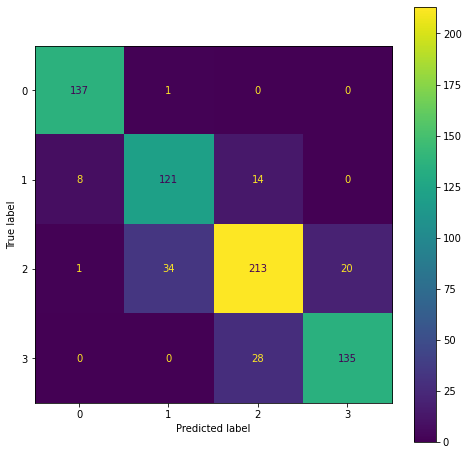

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       138
           1       0.78      0.85      0.81       143
           2       0.84      0.79      0.81       268
           3       0.87      0.83      0.85       163

    accuracy                           0.85       712
   macro avg       0.86      0.87      0.86       712
weighted avg       0.85      0.85      0.85       712

Accuracy:85.11%


In [200]:
#Confusion matrix, initial rfc classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=rfc)

# 1st Refined Models - Best Estimator

### Decision Tree Refined Model

In [201]:
##Fit decision tree, applying parameters to refine search
dtc_param_grid1 = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [202]:
#criterion : which cost function for selecting the next tree node. Mostly used ones are gini/entropy.
#max depth : it is the maximum allowed depth of the decision tree.
#minimum samples split : It is the minimum nodes required to split an internal node.
#minimum samples leaf : minimum samples that are required to be at the leaf node.

In [203]:
#GridSearchCV on DTC
dtc_grid_search1 = GridSearchCV(dtc, dtc_param_grid1, cv=3, return_train_score=True)

dtc_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [204]:
#Search for best estimator
bestdtcrefine1 = dtc_grid_search1.best_estimator_

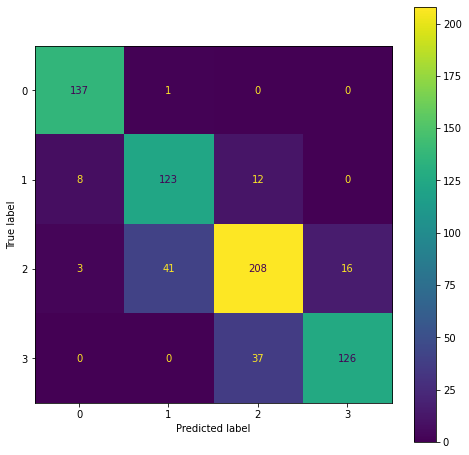

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.75      0.86      0.80       143
           2       0.81      0.78      0.79       268
           3       0.89      0.77      0.83       163

    accuracy                           0.83       712
   macro avg       0.84      0.85      0.84       712
weighted avg       0.84      0.83      0.83       712

Accuracy:83.43%


In [205]:
#Confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestdtcrefine1)

In [206]:
#search for best parameters
dtc_grid_search1.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [207]:
#1st Refine Model Test Score
bestdtcrefine1.score(X_test,y_test)

0.8342696629213483

In [208]:
#1st Refine Model Training Score
bestdtcrefine1.score(X_train,y_train)

0.9282700421940928

### KNN Refined Model

In [209]:
#Fit knn, applying parameters to refine search
knn_param_grid1 = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform','distance'],
    'algorithm': ['ball_tree','kd_tree','brute'],
    'p':[1,2,3]
}

In [210]:
#GridSearch on Knn
knn_grid_search1 = GridSearchCV(knn, knn_param_grid1, cv=3, return_train_score=True)
#Fit 1st Refine KNN to Train/Test
knn_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             return_train_score=True)

In [211]:
#best estimator
bestknnrefine1 = knn_grid_search1.best_estimator_

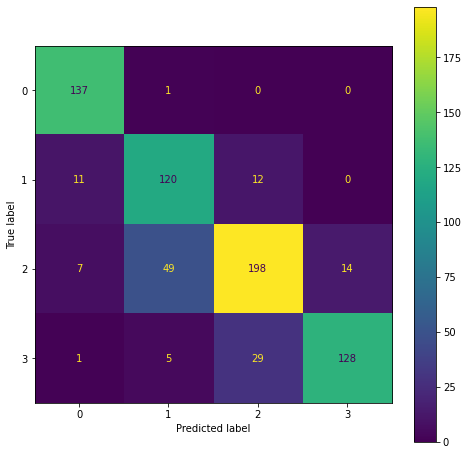

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       138
           1       0.69      0.84      0.75       143
           2       0.83      0.74      0.78       268
           3       0.90      0.79      0.84       163

    accuracy                           0.82       712
   macro avg       0.82      0.84      0.83       712
weighted avg       0.83      0.82      0.82       712

Accuracy:81.88%


In [212]:
#Knn confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestknnrefine1)

In [213]:
#search for best parameters
knn_grid_search1.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}

In [214]:
#knn model test score
bestknnrefine1.score(X_test,y_test)

0.8188202247191011

In [215]:
#knn model training score
bestknnrefine1.score(X_train,y_train)

0.9276672694394213

### Random Forest Refined

In [216]:
##Fit random forest, applying parameters to refine search
rfc_param_grid1 = {
    'n_estimators': [50,100],
    'criterion': ['gini','entropy'],
    'max_depth': [None,3, 5, 7],
    'min_samples_split': [1, 2, 4, 6],
    'min_samples_leaf': [1,2,3],
    'max_features': [None,'sqrt','log2'],
    'random_state': [7],
    
}

In [217]:
#Gridsearch on rfc
rfc_grid_search1 = GridSearchCV(rfc, rfc_param_grid1, cv=3,n_jobs=10, return_train_score=True)
#Fit GridSearch to Train/Test
rfc_grid_search1.fit(X_train, y_train)

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.83544304 0.84086799 0.84870404 0.84327908
 0.84267631 0.84388186        nan        nan 0.82820976 0.8318264
 0.82820976 0.8318264  0.82700422 0.82579867        nan        nan
 0.82278481 0.82459313 0.82278481 0.82459313 0.82278481 0.82459313
        nan        nan 0.84086799 0.84810127 0.8450874  0.84448463
 0.84569017 0.84448463        nan        nan 0.83062086 0.83725136
 0.83062086 0.83725136 0.83423749 0.83664858        nan        nan
 0.82218204 0.81916817 0.82218204 0.81916817 0.82218204 0.81916817
        nan        nan 0.84086799 0.84810127 0.8450874  0.84448463
 0.84569017 0.84448463        nan        nan 0.83062086 0.83725136
 0.83062086 0.83725136 0.83423749 0.83664858        nan        nan
 0.82218204 0.81916817 0.82218204 0.81916817 0.82218204 0.81916817
        nan        nan 0.67088608 0.670

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=10,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 7],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 4, 6],
                         'n_estimators': [50, 100], 'random_state': [7]},
             return_train_score=True)

In [218]:
#best estimator
bestrfcrefine1 = rfc_grid_search1.best_estimator_

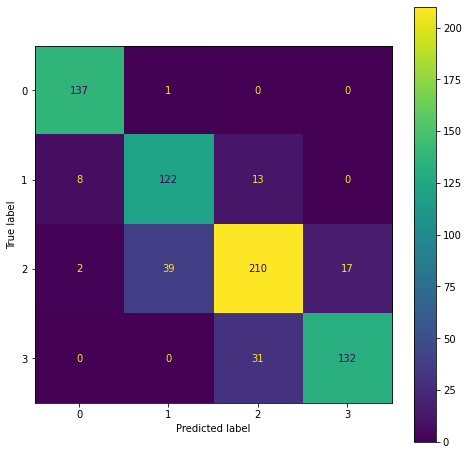

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.75      0.85      0.80       143
           2       0.83      0.78      0.80       268
           3       0.89      0.81      0.85       163

    accuracy                           0.84       712
   macro avg       0.85      0.86      0.85       712
weighted avg       0.85      0.84      0.84       712

Accuracy:84.41%


In [219]:
#rfc confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestrfcrefine1)

In [220]:
#best parameter
rfc_grid_search1.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50,
 'random_state': 7}

In [221]:
#rfc model test score
bestrfcrefine1.score(X_test,y_test)

0.8441011235955056

In [222]:
#rfc model training score
bestrfcrefine1.score(X_train,y_train)

0.9204339963833634

# 2nd Refined Models - Best Estimator

### Decision Tree Refined

In [223]:
##Fit decision tree, applying parameters to refine search
dtc_param_grid2 = {
    'criterion': ['gini'],
    'max_depth': [None],
    'min_samples_leaf': [1],
    'min_samples_split': [2]
}

In [224]:
#Search for best estimator
bestdtcrefine2 = dtc_grid_search1.best_estimator_

In [225]:
#GridSearchCV on DTC
dtc_grid_search = GridSearchCV(dtc, dtc_param_grid2, cv=3, return_train_score=True)

dtc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'min_samples_leaf': [1], 'min_samples_split': [2]},
             return_train_score=True)

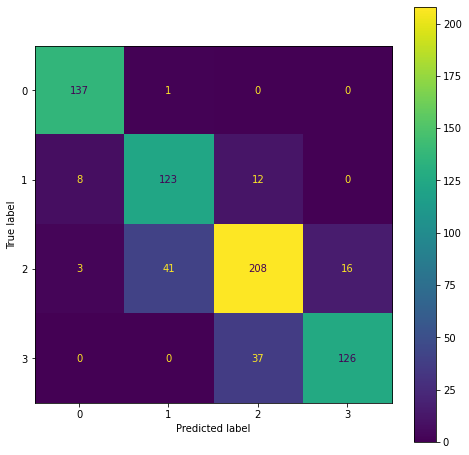

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.75      0.86      0.80       143
           2       0.81      0.78      0.79       268
           3       0.89      0.77      0.83       163

    accuracy                           0.83       712
   macro avg       0.84      0.85      0.84       712
weighted avg       0.84      0.83      0.83       712

Accuracy:83.43%


In [226]:
#Confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestdtcrefine2)

In [227]:
#dtc model test score
bestdtcrefine2.score(X_test,y_test)

0.8342696629213483

In [228]:
#dtc model training score
bestdtcrefine2.score(X_train,y_train)

0.9282700421940928

### KNN Refined Model

In [229]:
##Fit knn, applying parameters to refine search
knn_para_grid2 = {
    'algorithm': ['brute'],
    'n_neighbors': [5],
    'p': [1],
    'weights': ['distance']
}

In [230]:
#GridSearch on Knn
knn_grid_search1 = GridSearchCV(knn, knn_para_grid2, cv=3, return_train_score=True)

knn_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['brute'], 'n_neighbors': [5], 'p': [1],
                         'weights': ['distance']},
             return_train_score=True)

In [231]:
#Search for best estimator
bestknnrefine2 = dtc_grid_search1.best_estimator_

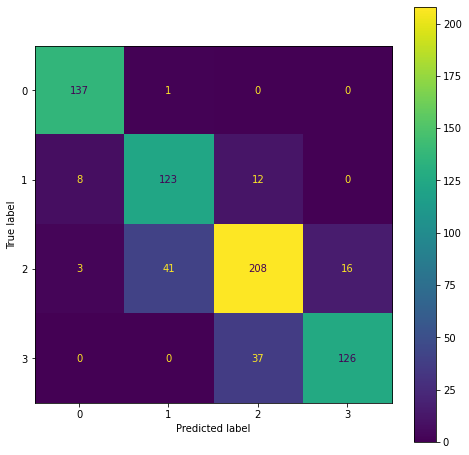

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.75      0.86      0.80       143
           2       0.81      0.78      0.79       268
           3       0.89      0.77      0.83       163

    accuracy                           0.83       712
   macro avg       0.84      0.85      0.84       712
weighted avg       0.84      0.83      0.83       712

Accuracy:83.43%


In [232]:
#Knn confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestknnrefine2)

In [233]:
#rfc model test score
bestknnrefine2.score(X_test,y_test)

0.8342696629213483

In [234]:
#rfc model training score
bestknnrefine2.score(X_train,y_train)

0.9282700421940928

### Random Forest Refined

In [235]:
##Fit rfc, applying parameters to refine search
rfc_param_grid2 = {
    'criterion':['gini'],
    'max_depth':[None],
    'max_features':['sqrt'],
    'min_samples_leaf':[1],
    'min_samples_split':[2],
    'n_estimators':[100],
    'random_state':[7]
}

In [236]:
#GridSearch on rfc
rfc_grid_search1 = GridSearchCV(rfc, rfc_param_grid2, cv=3,n_jobs=10, return_train_score=True)

rfc_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=10,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100],
                         'random_state': [7]},
             return_train_score=True)

In [237]:
#best estimator
bestrfcrefine2 = rfc_grid_search1.best_estimator_

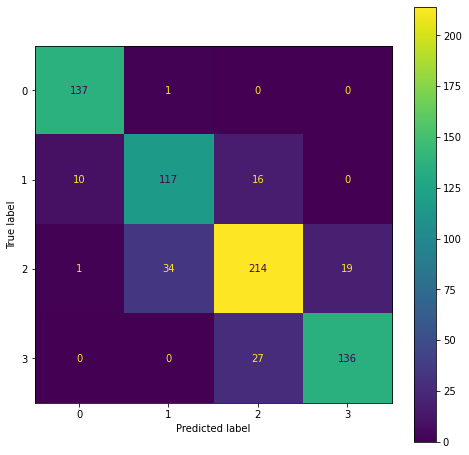

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.77      0.82      0.79       143
           2       0.83      0.80      0.82       268
           3       0.88      0.83      0.86       163

    accuracy                           0.85       712
   macro avg       0.85      0.86      0.86       712
weighted avg       0.85      0.85      0.85       712

Accuracy:84.83%


In [238]:
#rfc confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestrfcrefine2)

In [239]:
#rfc model test score
bestrfcrefine2.score(X_test,y_test)

0.848314606741573

In [240]:
#rfc model training score
bestrfcrefine2.score(X_train,y_train)

0.9282700421940928

In [241]:
# Random Forest Refined is our winner

# Highest overall accuracy

# Least damaging by not having nearly as many misrated M/T/ET games as E

# F1 is the metric most important to us. As combination of accuracy and recall this ensures the program be trained enough

# to not misrate a higher class game as a lower class game and also accurately rate and recognize lower class games

# INTERPRET

## Decision Tree Feature Importances

In [242]:
#What features carry the most weight
dtc.feature_importances_

array([0.01814279, 0.01355961, 0.0048168 , 0.06691635, 0.07543358,
       0.00815428, 0.02536082, 0.01327315, 0.10750179, 0.02132153,
       0.03755729, 0.0151965 , 0.00354683, 0.01623931, 0.0069748 ,
       0.07029045, 0.00688863, 0.01204735, 0.01724912, 0.01490786,
       0.15477959, 0.00104884, 0.00504122, 0.00714763, 0.02160627,
       0.02058509, 0.1377079 , 0.0151141 , 0.03459815, 0.01318498,
       0.00360497, 0.03020242])

In [243]:
Feature_Importances=pd.DataFrame({"feature":X_train.columns,"importance":dtc.feature_importances_})
Feature_Importances.sort_values("importance")

,feature,importance
21,nudity,0.001049
12,mature_humor,0.003547
30,use_of_drugs_and_alcohol,0.003605
2,animated_blood,0.004817
22,partial_nudity,0.005041
16,mild_language,0.006889
14,mild_cartoon_violence,0.006975
23,sexual_content,0.007148
5,cartoon_violence,0.008154
17,mild_lyrics,0.012047


## Random Forest Feature Importances

In [244]:
#What features carry the most weight
rfc.feature_importances_

array([0.02524986, 0.01731054, 0.00537012, 0.0979108 , 0.07372674,
       0.01384594, 0.02342668, 0.00901818, 0.10657421, 0.02517648,
       0.03802084, 0.01145615, 0.00406612, 0.02203501, 0.01027507,
       0.03908972, 0.00933036, 0.01540646, 0.01718446, 0.01981668,
       0.10878543, 0.00300053, 0.00956335, 0.01010271, 0.01907416,
       0.02188809, 0.11626442, 0.02758364, 0.03379497, 0.01357585,
       0.00801854, 0.0440579 ])

In [245]:
# Feature Importances Into ordered columns
Feature_Importances=pd.DataFrame({"feature":X_train.columns,"importance":rfc.feature_importances_})
Feature_Importances.sort_values("importance")

,feature,importance
21,nudity,0.003001
12,mature_humor,0.004066
2,animated_blood,0.005370
30,use_of_drugs_and_alcohol,0.008019
7,drug_reference,0.009018
16,mild_language,0.009330
22,partial_nudity,0.009563
23,sexual_content,0.010103
14,mild_cartoon_violence,0.010275
11,lyrics,0.011456


In [246]:
combined_csv.groupby("esrb_rating")["no_descriptors"].value_counts()
#How many No Descriptors exist in each category

esrb_rating  no_descriptors
0            1                 311
             0                 196
1            0                 504
             1                  16
2            0                 826
             1                  42
3            0                 472
             1                   4
Name: no_descriptors, dtype: int64

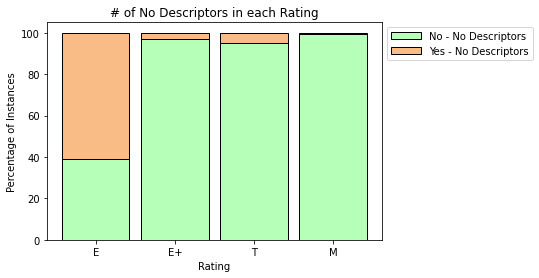

In [247]:
# Data
r = [0,1,2,3]
No_Descriptor = {'No': [201, 512, 830, 473], 'Yes': [315, 17, 43, 4]}
df = pd.DataFrame(No_Descriptor)

#From raw value to percentage
totals = [i+j for i,j in zip(df['No'], df['Yes'])]
greenBars = [i / j * 100 for i,j in zip(df['No'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['Yes'], totals)]
# plot
barWidth = 0.85
names = ('E','E+','T','M')
# Create Green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='black', width=barWidth, label="No - No Descriptors")
# Create Orange Bars
plt.bar(r, orangeBars,bottom=greenBars, color='#f9bc86', edgecolor='black', width=barWidth, label="Yes - No Descriptors")
# Custom X axis
plt.xticks(r, names)
plt.xlabel("Rating")
# Custom Y axis
plt.ylabel("Percentage of Instances")
# Legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, handlelength=3)
# Title
plt.title(label='# of No Descriptors in each Rating')
# Show Graphic
plt.show()

- No Descriptors has a significant impact on the E ratings

|                  | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| 0 = E            | 93%       | 99%    | 96%      | 138     |
| 1 = ET+          | 74%       | 85%    | 79%      | 143     |
| 2 = T            | 84%       | 78%    | 80%      | 268     |
| 3 = M            | 89%       | 82%    | 85%      | 163     |
|                  |           |        |          |         |
| Weighted Average | 85%       | 86%    | 85%      | 712     |
| Accuracy: 84.41% |           |        |          |         |

- F1 Score was determined to be my most important metric, as I wanted both the accuracy in ability to correctly predict a games rating, but also a high recall so as to not accidently rate a game E when it really should be rated M.

- The model is effective at distinguishing between the extremes in the rating system, and shows subsequent robustness in its ability to to correctly rate games rated T. Some bleedthough and mislabeling occurs mostly between the steps of classes E and ET, ET and T.

# CONCLUSIONS & RECCOMENDATIONS

- Conclusion
    - Model can be used to verify/quality control video game products with aspect of proper identification and recall to keep games from being misrated. While misratings between each tier can be addressed at multiple points across a games production and development, ensuring games do not get misrated beyond one tier or more is paramount. 
    - Games that need their content adjusted to fit a specific rating may not need extensive changes to fit the rating of the appropriate target audience.

- Recommendations
    - Use for quality control to be used in tandem with more evaluation methods.
    - Can help identify potential factors for/against rating
    - Effective check for minor protection for mislabeled M rated games

- Next steps
    - Research what makes up 'No Descriptors' category to futher analyze its impact on E Rating
    - Explore further correlations and groupings to improve and optimize all models for different scenarios